https://github.com/XMK233/GraphNeuralNetwork

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#基于Cora数据集的GCN节点分类" data-toc-modified-id="基于Cora数据集的GCN节点分类-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>基于Cora数据集的GCN节点分类</a></span><ul class="toc-item"><li><span><a href="#SetUp" data-toc-modified-id="SetUp-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SetUp</a></span></li><li><span><a href="#数据准备" data-toc-modified-id="数据准备-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>数据准备</a></span></li><li><span><a href="#图卷积层定义" data-toc-modified-id="图卷积层定义-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>图卷积层定义</a></span></li><li><span><a href="#模型定义" data-toc-modified-id="模型定义-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>模型定义</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>模型训练</a></span></li></ul></li></ul></div>

# 基于Cora数据集的GCN节点分类

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/FighterLYL/GraphNeuralNetwork/blob/master/chapter5/GCN_Cora.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

在Colab中运行时可以通过`代码执行程序->更改运行时类型`选择使用`GPU`

## SetUp

In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

## 数据准备

In [2]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])


def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


class CoraData(object):
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="../data/cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘

        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False

        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: ../data/cora
                缓存数据路径: {data_root}/ch5_cached.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据

        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "ch5_cached.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", adjacency.shape)
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix( ## 用法参考 https://zhuanlan.zhihu.com/p/40581747 
            (
                np.ones(len(edge_index)), ## 稀疏矩阵里面的值。
                (edge_index[:, 0], edge_index[:, 1]) ## 值对应的坐标。
            ),
            shape=(num_nodes, num_nodes), 
            dtype="float32"
        )
        return adjacency

    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def normalization(adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()


In [3]:
ix = [0, 1, 2]
iy = [1, 2, 3]
val = [1, 1, 1]

In [4]:
mx = sp.coo_matrix(
    (val, (ix, iy)),
    shape=(4, 4)
)

In [5]:
mx.todense()

matrix([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

In [6]:
mx.sum(1)

matrix([[1],
        [1],
        [1],
        [0]])

## 图卷积层定义

In [7]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'


## 模型定义

读者可以自己对GCN模型结构进行修改和实验

In [8]:
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn_0 = GraphConvolution(16, 48)
        self.gcn_1 = GraphConvolution(48, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature, cmplx = False):
        if cmplx: ## 虽然我尝试增加了层数，但是效果更差了。可能是因为过拟合了吧。
            h = self.gcn1(adjacency, feature)
            h = F.relu(h)
            h = F.dropout(h, 0.5, training=self.training)
            h = self.gcn_0(adjacency, h)
            h = F.relu(h)
            h = F.dropout(h, 0.5, training=self.training)
            h = self.gcn_1(adjacency, h)
            h = F.relu(h)
            h = F.dropout(h, 0.5, training=self.training)
            logits = self.gcn2(adjacency, h)
        else:
            h = F.relu(self.gcn1(adjacency, feature))
            logits = self.gcn2(adjacency, h)
        return logits


## 模型训练

In [9]:
# 超参数定义
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 800
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

ADHW
* A: adjacency，这是不会变的
* D: 度矩阵，这是不会变的
* H: 输入输出矩阵，这个会变
* W: 权重矩阵，这个会不一样


In [10]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData(data_root="../originalDataset/planetoid/data/").data
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)

normalize_adjacency = CoraData.normalization(dataset.adjacency)   # 规范化邻接矩阵，用那个DAD方法。

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

Using Cached file: ../originalDataset/planetoid/data/ch5_cached.pkl


In [11]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [12]:
tensor_y[tensor_train_mask]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2, 0, 0, 4, 3, 3, 3, 2, 3, 1, 3, 5, 3, 4, 6,
        3, 3, 6, 3, 2, 4, 3, 6, 0, 4, 2, 0, 1, 5, 4, 4, 3, 6, 6, 4, 3, 3, 2, 5,
        3, 4, 5, 3, 0, 2, 1, 4, 6, 3, 2, 2, 0, 0, 0, 4, 2, 0, 4, 5, 2, 6, 5, 2,
        2, 2, 0, 4, 5, 6, 4, 0, 0, 0, 4, 2, 4, 1, 4, 6, 0, 4, 2, 4, 6, 6, 0, 0,
        6, 5, 0, 6, 0, 2, 1, 1, 1, 2, 6, 5, 6, 1, 2, 2, 1, 5, 5, 5, 6, 5, 6, 5,
        5, 1, 6, 6, 1, 5, 1, 6, 5, 5, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history


In [14]:
# 测试函数
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()


In [15]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


In [16]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 1.9362, TrainAcc 0.1571, ValAcc 0.1580
Epoch 001: Loss 1.9873, TrainAcc 0.1429, ValAcc 0.0580
Epoch 002: Loss 2.9941, TrainAcc 0.1429, ValAcc 0.0720
Epoch 003: Loss 2.1287, TrainAcc 0.1857, ValAcc 0.2240
Epoch 004: Loss 2.1673, TrainAcc 0.1429, ValAcc 0.1140
Epoch 005: Loss 2.1940, TrainAcc 0.1429, ValAcc 0.1140
Epoch 006: Loss 2.1170, TrainAcc 0.15, ValAcc 0.1160
Epoch 007: Loss 2.0408, TrainAcc 0.1643, ValAcc 0.1340
Epoch 008: Loss 1.9923, TrainAcc 0.1643, ValAcc 0.2540
Epoch 009: Loss 1.9638, TrainAcc 0.1571, ValAcc 0.1920
Epoch 010: Loss 1.9483, TrainAcc 0.1714, ValAcc 0.1640
Epoch 011: Loss 1.9392, TrainAcc 0.1643, ValAcc 0.1760
Epoch 012: Loss 1.9340, TrainAcc 0.1786, ValAcc 0.2140
Epoch 013: Loss 1.9274, TrainAcc 0.2, ValAcc 0.2040
Epoch 014: Loss 1.9210, TrainAcc 0.1929, ValAcc 0.1660
Epoch 015: Loss 1.9129, TrainAcc 0.1929, ValAcc 0.1520
Epoch 016: Loss 1.8988, TrainAcc 0.2214, ValAcc 0.1540
Epoch 017: Loss 1.8802, TrainAcc 0.2, ValAcc 0.1380
Epoch 018: Loss 1.

Epoch 152: Loss 0.4601, TrainAcc 0.85, ValAcc 0.6160
Epoch 153: Loss 0.4473, TrainAcc 0.85, ValAcc 0.6060
Epoch 154: Loss 0.4388, TrainAcc 0.8643, ValAcc 0.6040
Epoch 155: Loss 0.4291, TrainAcc 0.8714, ValAcc 0.6020
Epoch 156: Loss 0.4204, TrainAcc 0.8786, ValAcc 0.6040
Epoch 157: Loss 0.4138, TrainAcc 0.8786, ValAcc 0.6100
Epoch 158: Loss 0.4083, TrainAcc 0.8714, ValAcc 0.6080
Epoch 159: Loss 0.4013, TrainAcc 0.8714, ValAcc 0.6080
Epoch 160: Loss 0.3904, TrainAcc 0.8786, ValAcc 0.6140
Epoch 161: Loss 0.3797, TrainAcc 0.9071, ValAcc 0.6180
Epoch 162: Loss 0.3734, TrainAcc 0.8857, ValAcc 0.6140
Epoch 163: Loss 0.3661, TrainAcc 0.9, ValAcc 0.6240
Epoch 164: Loss 0.3587, TrainAcc 0.9071, ValAcc 0.6320
Epoch 165: Loss 0.3517, TrainAcc 0.9071, ValAcc 0.6300
Epoch 166: Loss 0.3434, TrainAcc 0.9071, ValAcc 0.6220
Epoch 167: Loss 0.3360, TrainAcc 0.9071, ValAcc 0.6280
Epoch 168: Loss 0.3264, TrainAcc 0.9071, ValAcc 0.6360
Epoch 169: Loss 0.3182, TrainAcc 0.9071, ValAcc 0.6240
Epoch 170: Loss 0

Epoch 307: Loss 0.0289, TrainAcc 1.0, ValAcc 0.5860
Epoch 308: Loss 0.0288, TrainAcc 1.0, ValAcc 0.5900
Epoch 309: Loss 0.0287, TrainAcc 1.0, ValAcc 0.5860
Epoch 310: Loss 0.0286, TrainAcc 1.0, ValAcc 0.5900
Epoch 311: Loss 0.0285, TrainAcc 1.0, ValAcc 0.5860
Epoch 312: Loss 0.0286, TrainAcc 1.0, ValAcc 0.5940
Epoch 313: Loss 0.0285, TrainAcc 1.0, ValAcc 0.5840
Epoch 314: Loss 0.0284, TrainAcc 1.0, ValAcc 0.5940
Epoch 315: Loss 0.0283, TrainAcc 1.0, ValAcc 0.5880
Epoch 316: Loss 0.0282, TrainAcc 1.0, ValAcc 0.5880
Epoch 317: Loss 0.0281, TrainAcc 1.0, ValAcc 0.5880
Epoch 318: Loss 0.0281, TrainAcc 1.0, ValAcc 0.5900
Epoch 319: Loss 0.0280, TrainAcc 1.0, ValAcc 0.5900
Epoch 320: Loss 0.0279, TrainAcc 1.0, ValAcc 0.5900
Epoch 321: Loss 0.0279, TrainAcc 1.0, ValAcc 0.5920
Epoch 322: Loss 0.0279, TrainAcc 1.0, ValAcc 0.5840
Epoch 323: Loss 0.0280, TrainAcc 1.0, ValAcc 0.5980
Epoch 324: Loss 0.0281, TrainAcc 1.0, ValAcc 0.5860
Epoch 325: Loss 0.0280, TrainAcc 1.0, ValAcc 0.5960
Epoch 326: L

Epoch 465: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6080
Epoch 466: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6060
Epoch 467: Loss 0.0240, TrainAcc 1.0, ValAcc 0.6040
Epoch 468: Loss 0.0242, TrainAcc 1.0, ValAcc 0.6040
Epoch 469: Loss 0.0243, TrainAcc 1.0, ValAcc 0.6040
Epoch 470: Loss 0.0241, TrainAcc 1.0, ValAcc 0.6060
Epoch 471: Loss 0.0239, TrainAcc 1.0, ValAcc 0.6040
Epoch 472: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6040
Epoch 473: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6100
Epoch 474: Loss 0.0241, TrainAcc 1.0, ValAcc 0.6080
Epoch 475: Loss 0.0240, TrainAcc 1.0, ValAcc 0.6020
Epoch 476: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6080
Epoch 477: Loss 0.0238, TrainAcc 1.0, ValAcc 0.6040
Epoch 478: Loss 0.0237, TrainAcc 1.0, ValAcc 0.6000
Epoch 479: Loss 0.0236, TrainAcc 1.0, ValAcc 0.6000
Epoch 480: Loss 0.0235, TrainAcc 1.0, ValAcc 0.6020
Epoch 481: Loss 0.0235, TrainAcc 1.0, ValAcc 0.6020
Epoch 482: Loss 0.0236, TrainAcc 1.0, ValAcc 0.5980
Epoch 483: Loss 0.0236, TrainAcc 1.0, ValAcc 0.6100
Epoch 484: L

Epoch 623: Loss 0.4375, TrainAcc 0.95, ValAcc 0.3940
Epoch 624: Loss 0.4340, TrainAcc 0.9429, ValAcc 0.3960
Epoch 625: Loss 0.4307, TrainAcc 0.95, ValAcc 0.3880
Epoch 626: Loss 0.4273, TrainAcc 0.9571, ValAcc 0.3900
Epoch 627: Loss 0.4239, TrainAcc 0.9571, ValAcc 0.3940
Epoch 628: Loss 0.4205, TrainAcc 0.9571, ValAcc 0.3880
Epoch 629: Loss 0.4174, TrainAcc 0.9571, ValAcc 0.4040
Epoch 630: Loss 0.4141, TrainAcc 0.9571, ValAcc 0.3940
Epoch 631: Loss 0.4107, TrainAcc 0.9571, ValAcc 0.4020
Epoch 632: Loss 0.4075, TrainAcc 0.9571, ValAcc 0.3960
Epoch 633: Loss 0.4046, TrainAcc 0.9571, ValAcc 0.4080
Epoch 634: Loss 0.4029, TrainAcc 0.9571, ValAcc 0.3900
Epoch 635: Loss 0.4013, TrainAcc 0.95, ValAcc 0.4200
Epoch 636: Loss 0.3987, TrainAcc 0.9571, ValAcc 0.3920
Epoch 637: Loss 0.3943, TrainAcc 0.9571, ValAcc 0.4020
Epoch 638: Loss 0.3902, TrainAcc 0.9571, ValAcc 0.4100
Epoch 639: Loss 0.3890, TrainAcc 0.9571, ValAcc 0.3980
Epoch 640: Loss 0.3863, TrainAcc 0.9571, ValAcc 0.4080
Epoch 641: Loss 

Epoch 775: Loss 0.3950, TrainAcc 0.9286, ValAcc 0.3860
Epoch 776: Loss 0.3434, TrainAcc 0.9286, ValAcc 0.3800
Epoch 777: Loss 0.3766, TrainAcc 0.9286, ValAcc 0.4080
Epoch 778: Loss 0.3620, TrainAcc 0.9286, ValAcc 0.4140
Epoch 779: Loss 0.3579, TrainAcc 0.9286, ValAcc 0.3880
Epoch 780: Loss 0.3693, TrainAcc 0.9357, ValAcc 0.3960
Epoch 781: Loss 0.3368, TrainAcc 0.9214, ValAcc 0.4140
Epoch 782: Loss 0.3495, TrainAcc 0.9357, ValAcc 0.3840
Epoch 783: Loss 0.3346, TrainAcc 0.9429, ValAcc 0.3860
Epoch 784: Loss 0.3336, TrainAcc 0.9286, ValAcc 0.4100
Epoch 785: Loss 0.3457, TrainAcc 0.9429, ValAcc 0.3940
Epoch 786: Loss 0.3219, TrainAcc 0.9357, ValAcc 0.3740
Epoch 787: Loss 0.3347, TrainAcc 0.9286, ValAcc 0.4000
Epoch 788: Loss 0.3259, TrainAcc 0.9286, ValAcc 0.3960
Epoch 789: Loss 0.3220, TrainAcc 0.9357, ValAcc 0.3740
Epoch 790: Loss 0.3277, TrainAcc 0.9429, ValAcc 0.3980
Epoch 791: Loss 0.3129, TrainAcc 0.9357, ValAcc 0.4060
Epoch 792: Loss 0.3162, TrainAcc 0.9429, ValAcc 0.3920
Epoch 793:

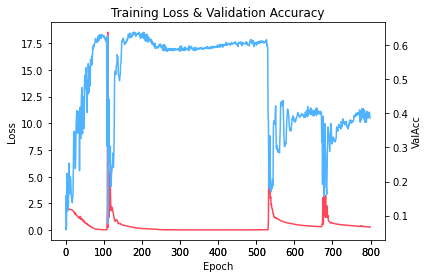

In [17]:
plot_loss_with_acc(loss, val_acc)

In [18]:
test_logits.shape

(1000, 7)

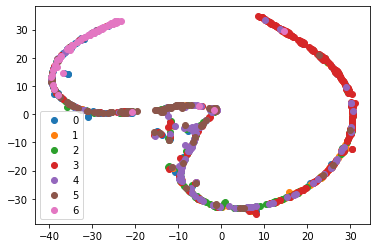

In [19]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()

In [20]:
out.shape

(1000, 2)